## XGBoost

__파이썬 래퍼 XGBoost__ <br>
- 파라미터
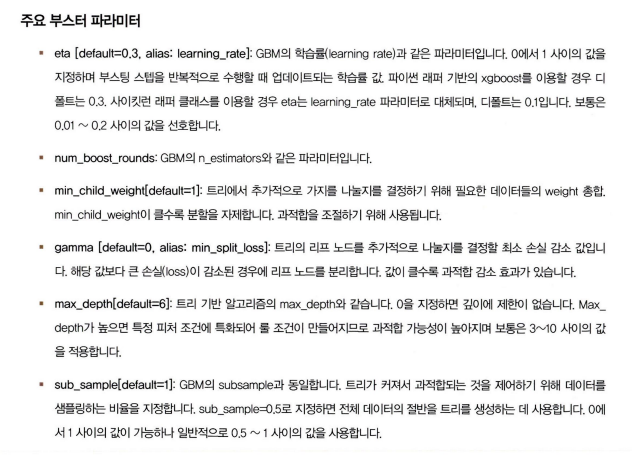 <br>
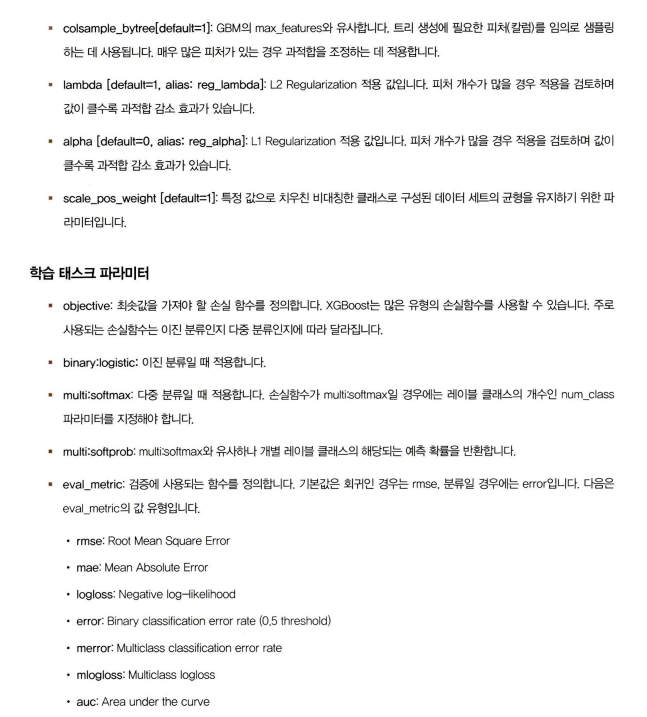

- 과적합 해결방법
    1. eta 값을 낮춘다(0.01~0.1). eta값을 낮출 경우 num_round(또는 n_estimators)는 반대로 높여줘야 한다.
    2. max_depth 값을 낮춘다.
    3. min_child_weight 값을 높인다.
    4. gamma값을 높인다.
    5. subsample과 colsample_bytree를 조정하는 것도 트리가 복잡하게 생성되는 것을 막아 과적합 문제 해결에 도움.

- GBM + 수행속도 향상(Early_stopping)

__Sklearn 래퍼 XGBoost__
- 파라미터 
    - eta -> learning_rate
    - sub_sample -> subsample
    - lambda -> reg_lambda
    - alpha -> reg_alpha

In [2]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### 파이썬 래퍼 Xgboost

In [3]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


> 양성 benign이 357개, 악성 malignant가 212개

In [5]:
# cancer_df 에서 feature용 Dataframe과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label 임. feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 컬럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

In [6]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


> 파이썬 래퍼 xgboost는 sklearn.XGBoost와 달리 XGBoost만의 전용 데이터 객체인 DMatrix를 사용한다. 때문에 numpy,pandas로 되어 있는 학습용, 검증, 테스트용 데이터 세트를 모두 전용의 데이터 객체인 DMatrix로 생성하여 모델에 입력해줘야 한다. DMatrix의 주요 입력 파라미터는 data와 label이다. data는 피처 데이터세트이며, label은 분류의 경우 레이블 데이터 세트, 회귀의 경우 숫자형인 종속형 데이터 세트

In [7]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [8]:
params = {'max_depth':3,
          'eta':0.05,
          'objective':'binary:logistic', #이진분류이므로 목적함수는 이진로지스틱
          'eval_metric':'logloss'} # 오류함수 평가 성능지표는 logloss

# 부스팅 반복횟수
num_rounds = 400

In [9]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기
eval_list = [(dtr, 'train'), (dval, 'eval')] # 또는 evalist=[(dval, 'eval')]만 명기해도 무방

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

[50]	train-logloss:0.07784	eval-logloss:0.27104
[51]	train-logloss:0.07578	eval-logloss:0.26958
[52]	train-logloss:0.07384	eval-logloss:0.26869
[53]	train-logloss:0.07196	eval-logloss:0.26760
[54]	train-logloss:0.07021	eval-logloss:0.26661
[55]	train-logloss:0.06833	eval-logloss:0.26680
[56]	train-logloss:0.06671	eval-logloss:0.26517
[57]	train-logloss:0.06519	eval-logloss:0.26412
[58]	train-logloss:0.06368	eval-logloss:0.26444
[59]	train-logloss:0.06202	eval-logloss:0.26434
[60]	train-logloss:0.06048	eval-logloss:0.26208
[61]	train-logloss:0.05898	eval-logloss:0.26139
[62]	train-logloss:0.05756	eval-logloss:0.26155
[63]	train-logloss:0.05614	eval-logloss:0.26114
[64]	train-logloss:0.05486	eval-logloss:0.25973
[65]	train-logloss:0.05372	eval-logloss:0.25878
[66]	train-logloss:0.05263	eval-logloss:0.25758
[67]	train-logloss:0.05140	eval-logloss:0.25664
[68]	train-logloss:0.05019	eval-logloss:0.25625
[69]	train-logloss:0.04910	eval-logloss:0.25593
[70]	train-logloss:0.04806	eval-logloss:

> num_rounds를 400회로 설정했지만 251회에서 멈춘 것을 확인할 수 있다. 

> [201]	train-logloss:0.01103	eval-logloss:0.23533 에서 오차가 작은 것을 알 수 있다. 201번에서 251번까지 50회 동안 logloss값은 이보다 향상되지 않았기 때문에 더 이상 반복하지 않고 멈춘 것.

In [10]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x>0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
예측값 10개만 표시 [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('confusion_matrix:', confusion_matrix(y_test, preds))
print('정확도:', accuracy_score(y_test, preds))
print('정밀도:', precision_score(y_test, preds))
print('재현율:', recall_score(y_test, preds))
print('f1-score:', f1_score(y_test, preds))
print('roc_auc_score:', f1_score(y_test, preds))

confusion_matrix: [[35  2]
 [ 2 75]]
정확도: 0.9649122807017544
정밀도: 0.974025974025974
재현율: 0.974025974025974
f1-score: 0.974025974025974
roc_auc_score: 0.974025974025974


### 사이킷런 래퍼 XGBoost

In [12]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

[20]	validation_0-logloss:0.22320	validation_1-logloss:0.35374
[21]	validation_0-logloss:0.21363	validation_1-logloss:0.34704
[22]	validation_0-logloss:0.20487	validation_1-logloss:0.34206
[23]	validation_0-logloss:0.19634	validation_1-logloss:0.33621
[24]	validation_0-logloss:0.18830	validation_1-logloss:0.33178
[25]	validation_0-logloss:0.18093	validation_1-logloss:0.32774
[26]	validation_0-logloss:0.17374	validation_1-logloss:0.32297
[27]	validation_0-logloss:0.16695	validation_1-logloss:0.31855
[28]	validation_0-logloss:0.16059	validation_1-logloss:0.31495
[29]	validation_0-logloss:0.15450	validation_1-logloss:0.31173
[30]	validation_0-logloss:0.14875	validation_1-logloss:0.30735
[31]	validation_0-logloss:0.14329	validation_1-logloss:0.30463
[32]	validation_0-logloss:0.13807	validation_1-logloss:0.30242
[33]	validation_0-logloss:0.13325	validation_1-logloss:0.29922
[34]	validation_0-logloss:0.12864	validation_1-logloss:0.29722
[35]	validation_0-logloss:0.12429	validation_1-logloss:

> n_estimators=400으로 설정했지만 early_stopping_rounds를 50으로 설정하여 logloss가 가장 낮은 201번부터 50번 반복하는 동안 오차가 줄어들지 않아 조기중단한 것을 볼 수 있다.

> **하지만 조기중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 크다.**

In [13]:
# early_stopping_rounds를 10으로 설정하고 재학습.
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478


[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[16]	validation_0-logloss:0.26691	validation_1-logloss:0.38150
[17]	validation_0-logloss:0.25473	validation_1-logloss:0.37368


In [14]:
print('confusion_matrix:', confusion_matrix(y_test, preds))
print('정확도:', accuracy_score(y_test, preds))
print('정밀도:', precision_score(y_test, preds))
print('재현율:', recall_score(y_test, preds))
print('f1-score:', f1_score(y_test, preds))
print('roc_auc_score:', f1_score(y_test, preds))

confusion_matrix: [[35  2]
 [ 2 75]]
정확도: 0.9649122807017544
정밀도: 0.974025974025974
재현율: 0.974025974025974
f1-score: 0.974025974025974
roc_auc_score: 0.974025974025974


#### 피처의 중요도 확인

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

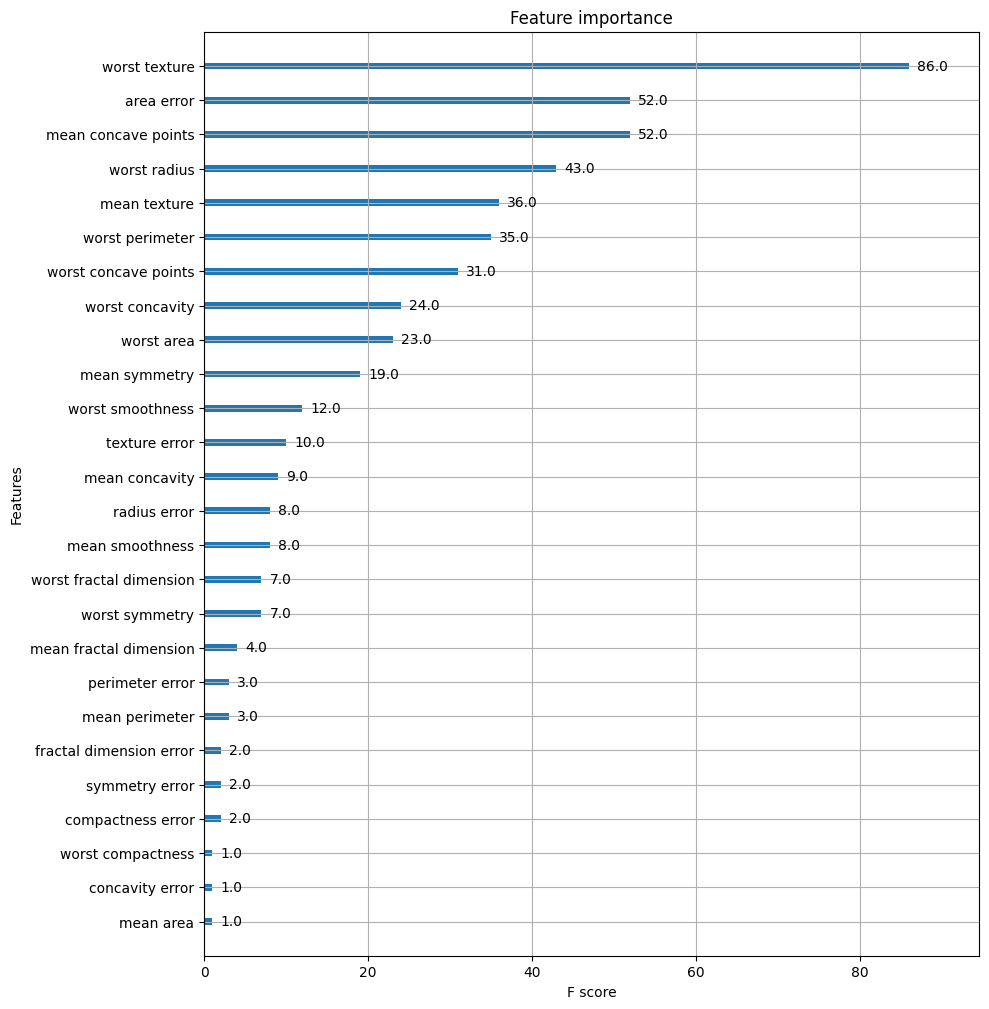

In [15]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)